In [6]:
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
CUSTOM_MODEL_NAME = 'my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

ROOT_WORKSPACE = 'workspace_tiffanies'

import os
paths = {
    'APIMODEL_PATH': 'object_detection',
    'WORKSPACE_PATH': ROOT_WORKSPACE,
    'ANNOTATION_PATH': os.path.join(ROOT_WORKSPACE,CUSTOM_MODEL_NAME,'model_data','data'),
    'CHECKPOINT_PATH': os.path.join(ROOT_WORKSPACE,CUSTOM_MODEL_NAME,'model_data','model'),
    'OUTPUT_PATH': os.path.join(ROOT_WORKSPACE,CUSTOM_MODEL_NAME,'model_data','model', 'export'), 
    'TFJS_PATH':os.path.join(ROOT_WORKSPACE,CUSTOM_MODEL_NAME,'model_data','model','tfjsexport'), 
    'IMAGE_PATH': os.path.join(ROOT_WORKSPACE,'images'),
    'PRETRAINED_MODEL_PATH': os.path.join(ROOT_WORKSPACE,CUSTOM_MODEL_NAME),
    'SCRIPTS_PATH': 'scripts'
}

files = {
    'PIPELINE_CONFIG':os.path.join(paths['CHECKPOINT_PATH'], 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(os.path.join(paths['CHECKPOINT_PATH'], 'export','saved_model'))

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 8.222107887268066 seconds


In [8]:
from object_detection.utils import label_map_util

category_index = label_map_util.create_category_index_from_labelmap(os.path.join(paths['ANNOTATION_PATH'], 'label_map.pbtxt'),use_display_name=True)

print(category_index)

{1: {'id': 1, 'name': 'burj'}, 2: {'id': 2, 'name': 'empire'}}


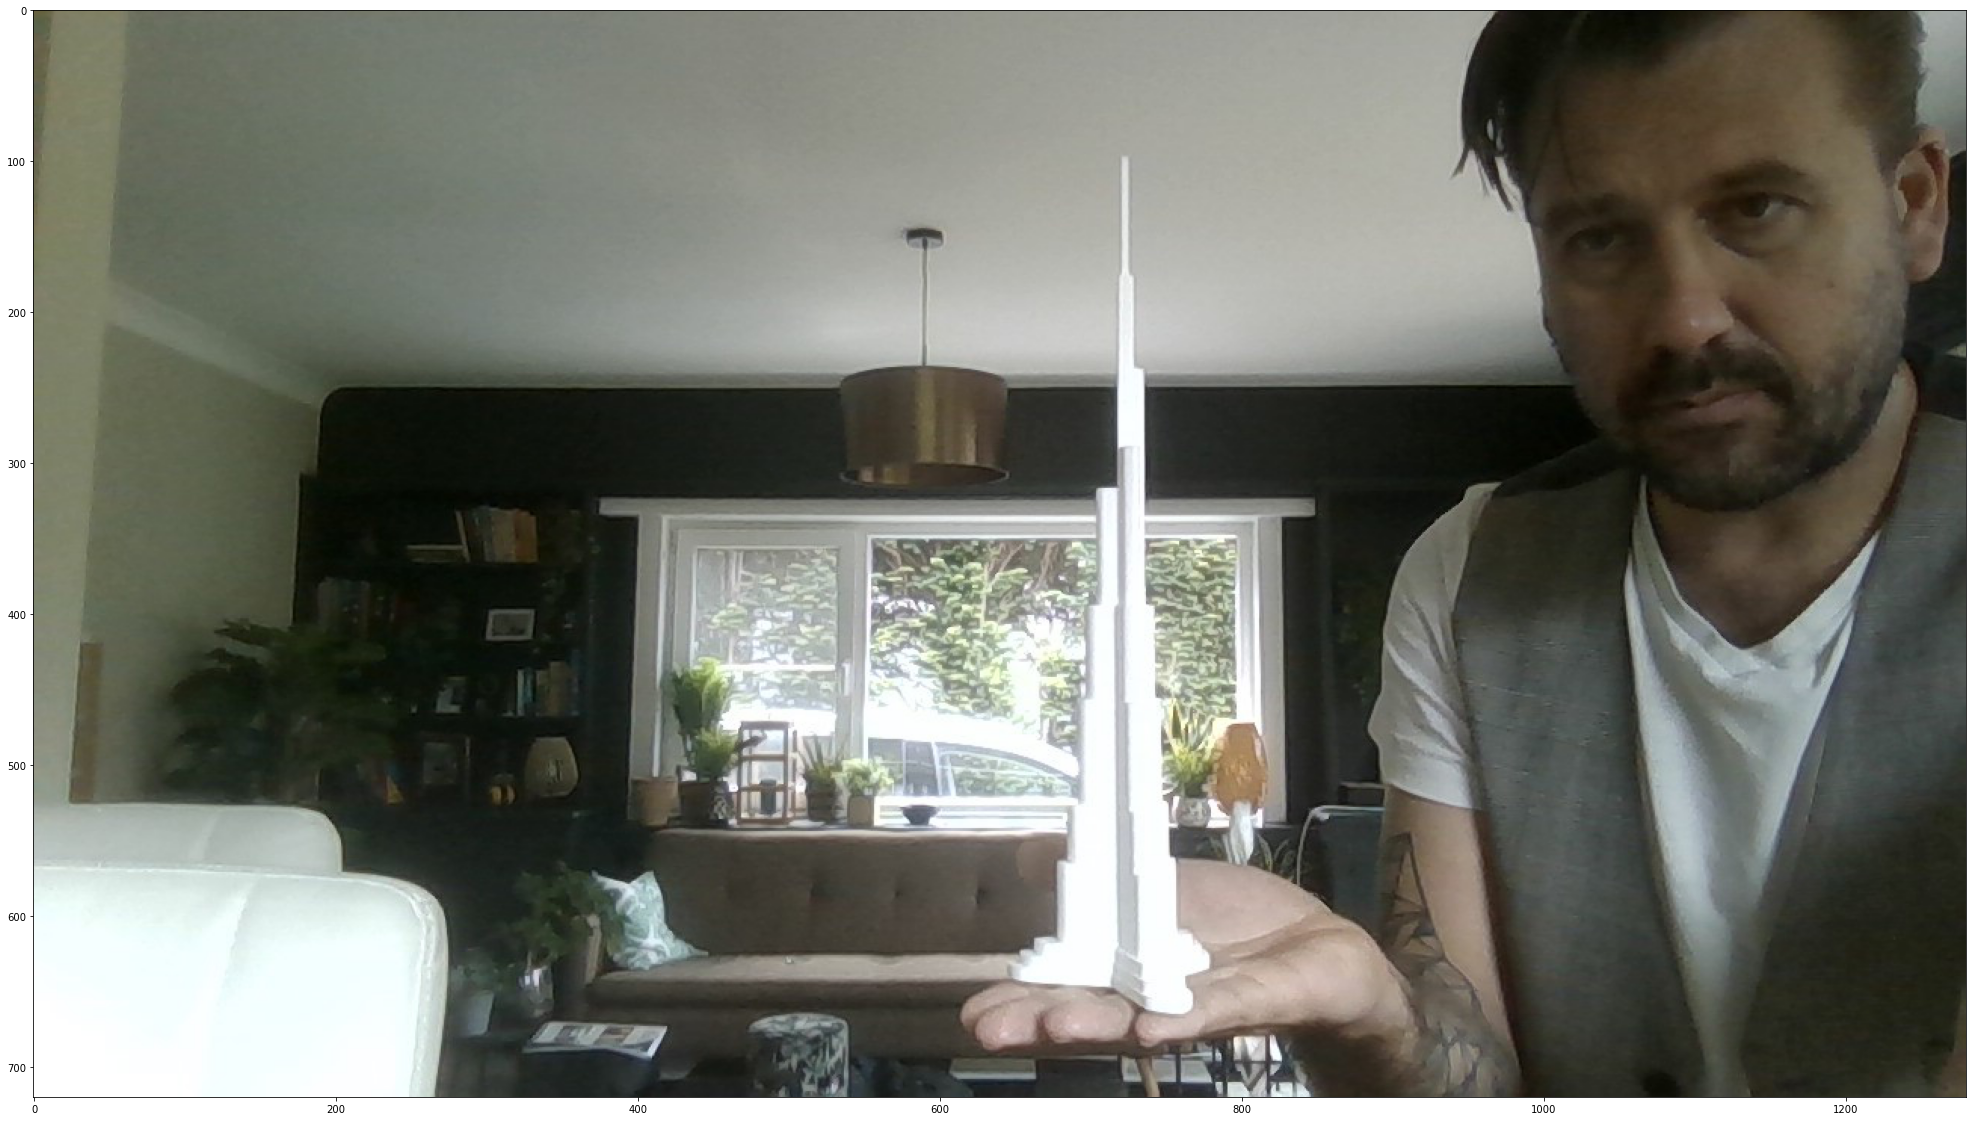

Done


In [22]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

image_np = load_image_into_numpy_array("34.jpg")
# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))

detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4,
      agnostic_mode=False)

f= plt.figure()
f.set_figwidth(40)
f.set_figheight(20)
plt.imshow(image_np_with_detections)
plt.show()
print('Done')
